In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np

import mag2exp

In [2]:
mesh = df.Mesh(
    p1=(-50e-9, -50e-9, -50e-9), p2=(50e-9, 50e-9, 50e-9), cell=(5e-9, 5e-9, 5e-9)
)


def ms_fun(pos):
    x, y, z = pos
    if abs(x) < 20e-9 and abs(y) < 20e-9 and abs(z) < 20e-9:
        return 1e6
    else:
        return 0


def v_fun(pos):
    x, y, z = pos
    if x > 0:
        return (1, 1, 0)
    else:
        return (-1, -1, 0)


field = df.Field(mesh, nvdim=3, value=(1, 0, 0), norm=ms_fun)

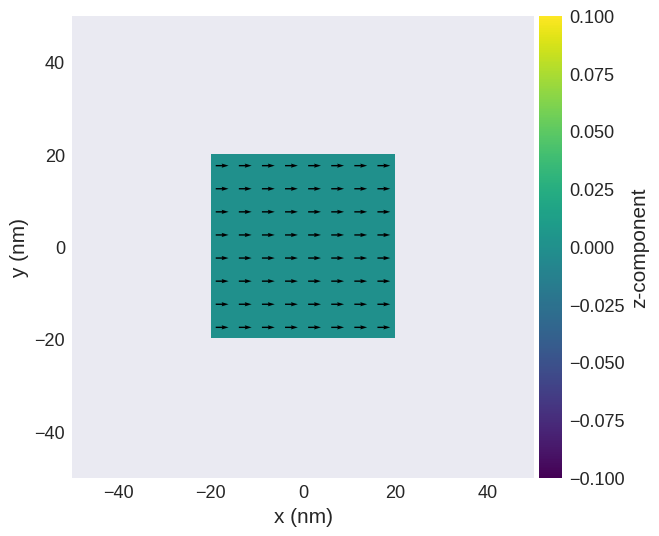

In [3]:
field.sel("z").mpl()


\begin{align*}
\bm{\mu} &= \int_V \bm{M} dV \\
&= \bm{M} V
\end{align*}

\begin{align*}
\bm{B} = \mu_0 (\bm{H} + \bm{M})
\end{align*}

\begin{align*}
\bm{T} &= \bm{\mu} \times \bm{B} \\
&= V \bm{M} \times \bm{B} \\
& = V \mu_0 \bm{M} \times (\bm{H} + \bm{M}) \\
& = V \mu_0 \bm{M} \times \bm{H}
\end{align*}

In [4]:
mag2exp.magnetometry.torque(field, (0, 1e6, 0))

(0.0, -1.8758328224066645e-12, 1256637.0614359186)

In [5]:
norm_field = df.Field(field.mesh, nvdim=1, value=(field.norm.array != 0))
volume = df.integral(norm_field * df.dV, direction="xyz")

In [6]:
a = mm.consts.mu0 * field & (0, 1e6, 0)
df.integral(a * df.dV, direction="xyz")
# a.average

(0.0, 0.0, 8.042477193189779e-17)

In [7]:
np.array(df.integral(a * df.dV, direction="xyz")) / volume

array([      0.       ,       0.       , 1256637.0614359])

In [8]:
b = mm.consts.mu0 * field.mesh.dV * field & (0, 1e6, 0)
np.sum(b.array, axis=(0, 1, 2))

array([0.00000000e+00, 0.00000000e+00, 8.04247719e-17])

```
mag2exp.magnetometry.torque(field, H, spatially_resolved=True)
mag2exp.magnetometry.torque_density(field, H, spatially_resolved=True) ???
```

In [9]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as oc

Running OOMMF (ExeOOMMFRunner)[2022/11/18 08:51]... (0.3 s)


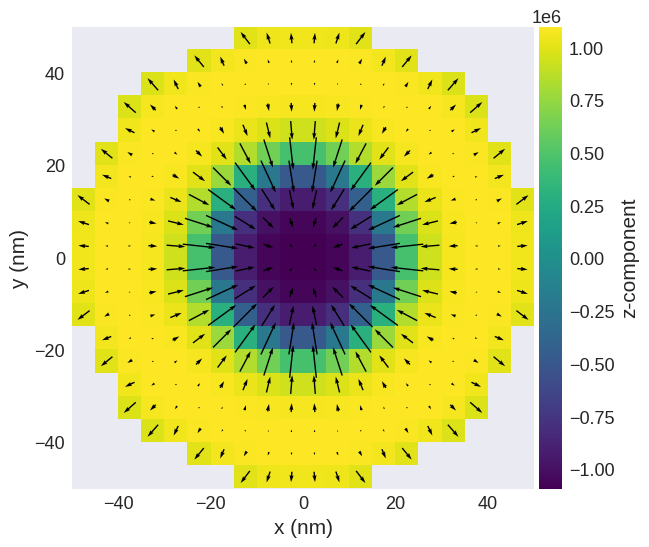

In [10]:
region = df.Region(p1=(-50e-9, -50e-9, 0), p2=(50e-9, 50e-9, 10e-9))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))
system = mm.System(name="skyrmion")

system.energy = (
    mm.Exchange(A=1.6e-11)
    + mm.DMI(D=4e-3, crystalclass="Cnv_z")
    + mm.UniaxialAnisotropy(K=0.51e6, u=(0, 0, 1))
    + mm.Demag()
    + mm.Zeeman(H=(0, 0, 2e5))
)
Ms = 1.1e6


def Ms_fun(pos):
    """Function to set magnitude of magnetisation: zero outside cylindric shape,
    Ms inside cylinder.

    Cylinder radius is 50nm.

    """
    x, y, z = pos
    if (x**2 + y**2) ** 0.5 < 50e-9:
        return Ms
    else:
        return 0


def m_init(pos):
    """Function to set initial magnetisation direction:
    -z inside cylinder (r=10nm),
    +z outside cylinder.
    y-component to break symmetry.

    """
    x, y, z = pos
    if (x**2 + y**2) ** 0.5 < 10e-9:
        return (0, 0, -1)
    else:
        return (0, 0, 1)


# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, nvdim=3, value=m_init, norm=Ms_fun)

# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.sel("z").mpl()

In [11]:
demag_field = mag2exp.util.calculate_demag_field(system.m)
torque = system.m & demag_field

In [14]:
torque.average

(6.866455078125e-07, -5.45501708984375e-06, 9.822845458984375e-07)

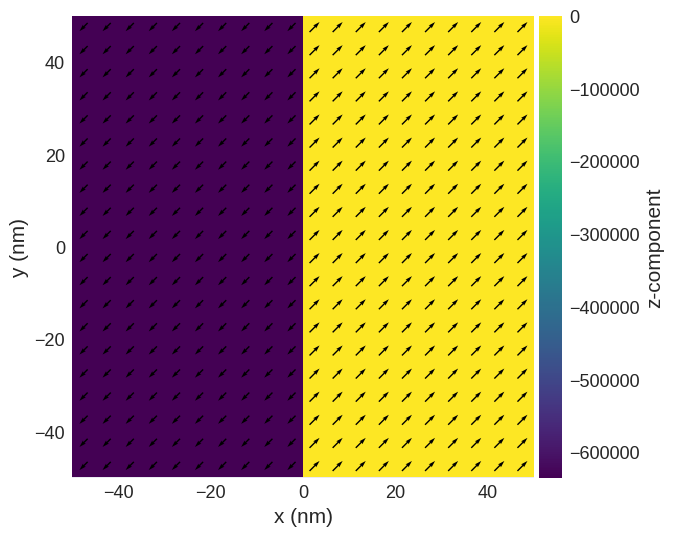

In [15]:
def value_fun(pos):
    x, y, z = pos
    if x > 0:
        return (1, 1, 0)
    else:
        return (-1, -1, -1)


field = df.Field(mesh, nvdim=3, value=value_fun, norm=Ms)
field.sel("z").mpl()

In [16]:
demag_field = mag2exp.util.calculate_demag_field(field)
torque = field & demag_field
torque.average

(-121709910577.51505, 81900586081.06538, 88565590507.03963)

In [17]:
system.m = field + (0.0, 0.0, 0.0)

Running OOMMF (ExeOOMMFRunner)[2022/11/18 08:55]... (1.8 s)


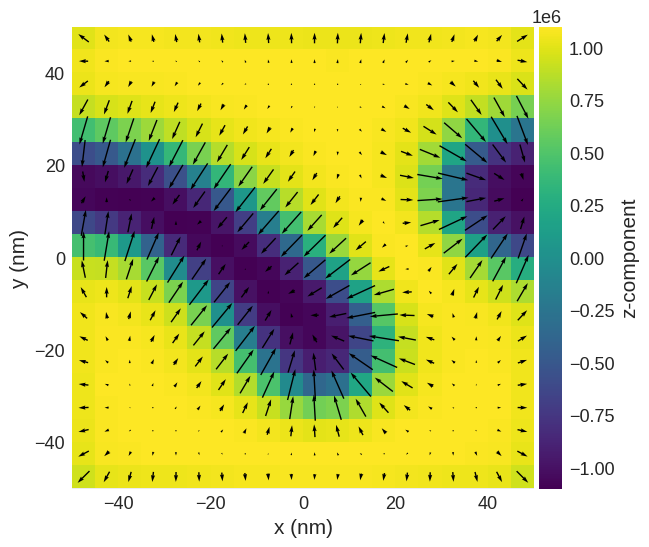

In [18]:
# minimize the energy
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.sel("z").mpl()

In [20]:
demag_field = mag2exp.util.calculate_demag_field(system.m)
torque = system.m & demag_field
torque.average

(-3435474632.6791463, 1973762526.327849, -823402332.9056026)

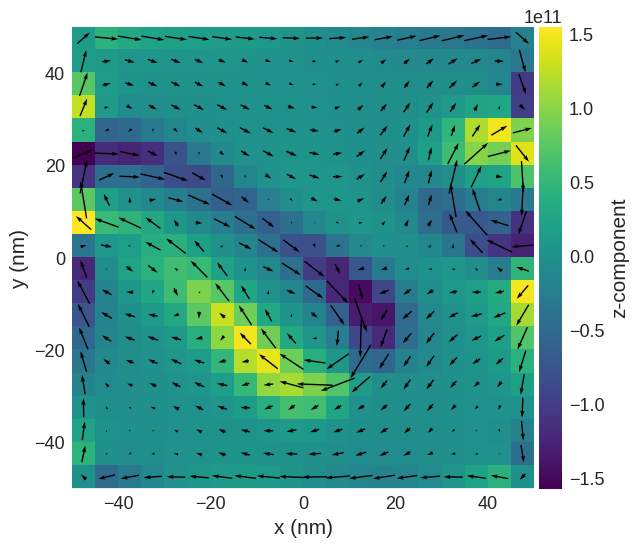

In [21]:
torque.sel("z").mpl()